In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

In [3]:
model = UNet1D()

# prepare data

In [5]:
import seisbench.data as sbd

# Load the dataset from the current directory
data = sbd.WaveformDataset("../data/waveform_dataset/")
print(data)

2025-04-21 11:39:06,752 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.
2025-04-21 11:39:06,757 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
2025-04-21 11:39:06,757 | seisbench | WARNING | Default output component order 'ZNE' does not match dataset component order 'ENZ'. Please make sure this is intended.


Unnamed dataset - 18640 traces


In [6]:
data.metadata

,index,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,...,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,bucket,tindex,split,trace_chunk,trace_component_order
0,0,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2.10,0.030,NaN,0,1,4,0,train,,ENZ
1,1,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2.10,0.030,NaN,2,0,9,0,test,,ENZ
2,2,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2.10,0.030,NaN,0,1,4,1,test,,ENZ
3,3,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2.10,0.030,NaN,2,0,7,0,train,,ENZ
4,4,uw10568748,2002-09-26T07:00:04.860000Z,48.481,-123.133,earthquake,22.748,2.90,md,0.030,...,2.90,0.030,NaN,0,1,3,0,test,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18635,18635,uw10751608,2008-09-17T22:05:19.870000Z,47.523,-121.810,earthquake,23.486,2.70,md,0.030,...,2.70,0.030,NaN,0,0,8,1874,train,,ENZ
18636,18636,uw10752393,2008-08-20T21:26:52.460000Z,46.675,-121.105,earthquake,-0.072,2.00,md,0.040,...,2.00,0.040,NaN,2,0,8,1875,train,,ENZ
18637,18637,uw10753338,2008-07-31T05:02:43.130000Z,48.152,-122.748,earthquake,55.880,3.87,ml,0.134,...,3.89,0.246,NaN,0,0,8,1876,test,,ENZ
18638,18638,uw10753338,2008-07-31T05:02:43.130000Z,48.152,-122.748,earthquake,55.880,3.87,ml,0.134,...,3.89,0.246,NaN,0,0,8,1877,train,,ENZ


In [7]:
from torch.utils.data import random_split, DataLoader
import seisbench.generate as sbg

test = data.test()

In [11]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}
model_labels = ["P", "S", "noise"]

test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(
        list(phase_dict.keys()), samples_before=3000, windowlen=6000,
        selection="random", strategy="variable"
    ),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model_labels, sigma=30, dim=0)
]

test_generator.add_augmentations(augmentations)

# Test the generator

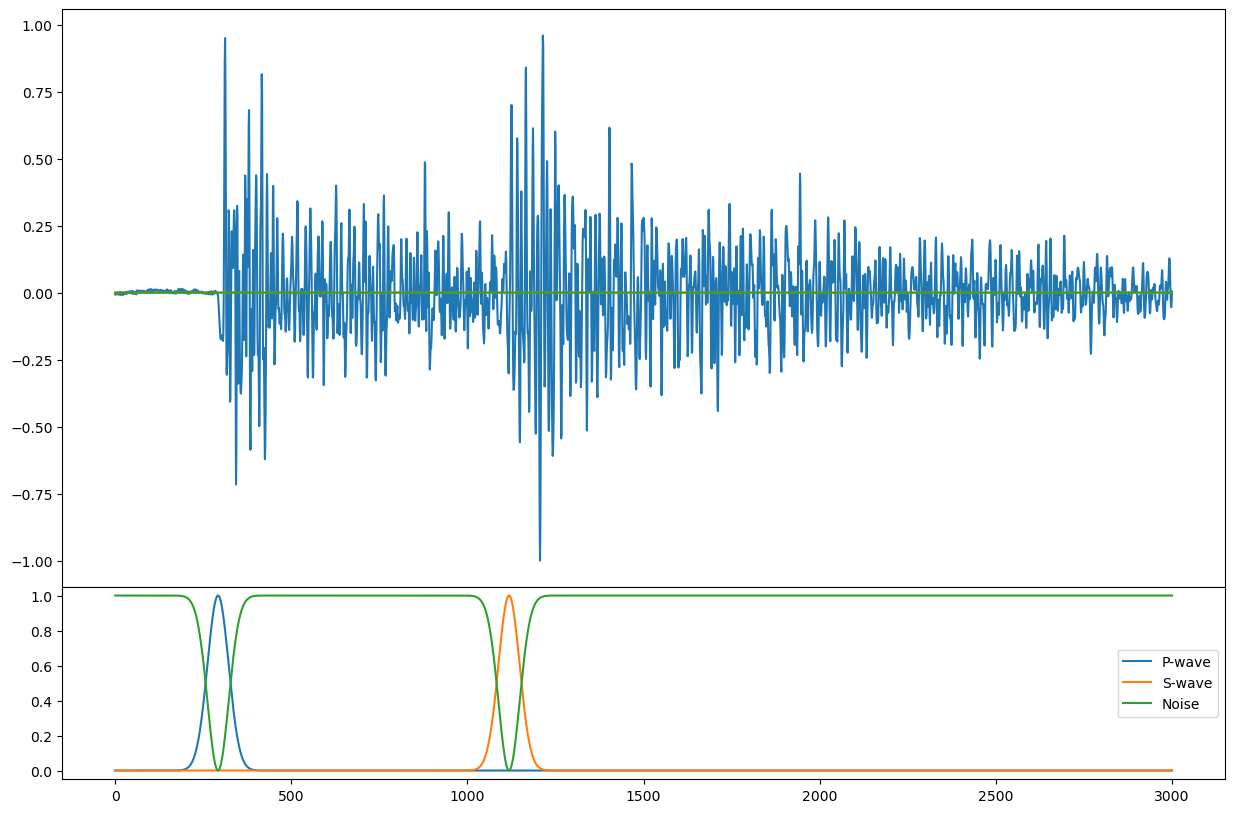

In [50]:
sample = test_generator[5]
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"][0].T,label='P-wave')
axs[1].plot(sample["y"][1].T,label='S-wave')
axs[1].plot(sample["y"][2].T,label='Noise')
plt.legend()

# Load the model and test it

In [125]:
import pandas as pd

# This cell loads the saved weights into the model.
model.load_state_dict(torch.load("../Loic/model_weights.pt",weights_only=True, map_location=torch.device('cpu')))
model.eval() 

# Defind a lambda that returns the index of where the timeseries=1
idx_max = lambda ts: np.where(ts==1)[0]

# Defind a lambda that returns the index of the maximum of a timeseries
find_max = lambda ts: np.argmax(ts)

# Plots?
plots=False

results =[]
for ii in range(len(test)):
    sample = test_generator[ii]
    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=torch.device('cpu')).unsqueeze(0))  # Add a fake batch dimension
        p_pred, s_pred, noise_pred = pred[0].cpu().numpy()
    
    p_idx_max = idx_max(sample["y"][0])
    s_idx_max = idx_max(sample["y"][1])
    p_pred_idx_max = find_max(p_pred)
    s_pred_idx_max = find_max(s_pred)

    if len(p_idx_max) == len(s_idx_max) == 1:
        results.append({"p_idx_max": p_idx_max[0], "s_idx_max": s_idx_max[0], 
                        "p_pred_idx_max": p_pred_idx_max, "s_pred_idx_max": s_pred_idx_max,
                        "p_pred_val": p_pred[p_pred_idx_max], "s_pred_val": s_pred[s_pred_idx_max]})

    if plots:

        # Plot timeseries
        fig = plt.figure(figsize=(15, 10))
        axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
        axs[0].plot(sample["X"].T)

        # Plot target timeseries
        axs[1].plot(sample["y"][0].T,label='P-wave', color="tab:red")
        if len(p_idx_max)>0:
            axs[1].plot(p_idx_max, sample["y"][0][p_idx_max], 'o', color="tab:red")
        axs[1].plot(sample["y"][1].T,label='S-wave', color='tab:blue')
        if len(s_idx_max)>0:
            axs[1].plot(s_idx_max, sample["y"][1][s_idx_max], 'o', color='tab:blue')

        # Plot prediction timeseries
        axs[1].plot(p_pred,label='P-wave Prediction', color="tab:red", linestyle='-.')
        axs[1].plot(p_pred_idx_max,p_pred[p_pred_idx_max], 'o', color="tab:red")
        axs[1].plot(s_pred,label='S-wave Predition', color='tab:blue', linestyle='-.')
        axs[1].plot(s_pred_idx_max,s_pred[s_pred_idx_max], 'o', color="tab:blue")
        # axs[1].plot(noise_pred,label='Noise Prediction', color="tab:green", linestyle='-.')
        plt.legend()

results = pd.DataFrame(results)

In [124]:
len(test)

9320